In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ÏãúÏä§ÌÖúÏù¥ WindowsÏùº Í≤ΩÏö∞
if platform.system() == 'Windows':
    plt.rc('font', family='Pretendard')
# macOSÏùº Í≤ΩÏö∞ ÏòàÏãú:
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')

# ÎßàÏù¥ÎÑàÏä§ Î∂ÄÌò∏ Íπ®Ïßê Î∞©ÏßÄ
plt.rcParams['axes.unicode_minus'] = False

In [21]:
# 1. ÌöåÏõêÏ†ïÎ≥¥
features_member = [
    'ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú',
    'ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†', 'ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©', 'ÌöåÏõêÏó¨Î∂Ä_Ïó∞Ï≤¥', 'ÎèôÏùòÏó¨Î∂Ä_ÌïúÎèÑÏ¶ùÏï°ÏïàÎÇ¥',
    'ÌÉàÌöåÌöüÏàò_ÎàÑÏ†Å', 'ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â1ÎÖÑÏù¥ÎÇ¥',
    'Í±∞Ï£ºÏãúÎèÑÎ™Ö',
    'Ïú†Ìö®Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨', 
    'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨', 
    'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨', 
    'Î≥¥Ïú†Ïó¨Î∂Ä_Ìï¥Ïô∏Í≤∏Ïö©_Î≥∏Ïù∏', 'Ïù¥Ïö©Ïó¨Î∂Ä_3M_Ìï¥Ïô∏Í≤∏Ïö©_Î≥∏Ïù∏',
    'Ïó∞ÌöåÎπÑÎ∞úÏÉùÏπ¥ÎìúÏàò_B0M', 'Í∏∞Î≥∏Ïó∞ÌöåÎπÑ_B0M', 'Ï†úÌú¥Ïó∞ÌöåÎπÑ_B0M'
]

In [3]:
selected_feature=(
    features_member)

In [5]:
print(len(selected_feature))         
print(type(selected_feature[0]))     
# 171 --> 119

16
<class 'str'>


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_parquet("../../data/ÌÜµÌï©_train_Îç∞Ïù¥ÌÑ∞.parquet")

# 2. ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Î∂ÑÎ¶¨
X = df[selected_feature].copy()
y = df["Segment"]

# 3. Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî©
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# Ïä§ÏºÄÏùºÎßÅ (DataFrame ÌòïÌÉú Ïú†ÏßÄ)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ÎùºÎ≤®Ïù∏ÏΩîÎî©
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation Î∂ÑÌï†
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost Î™®Îç∏ ÏÑ†Ïñ∏ (GPU Í∞ÄÏÜç)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# 8. ÌïôÏäµ
xgb_model.fit(X_train, y_train)

# 9. ÏòàÏ∏° Î∞è ÌèâÍ∞Ä
y_pred = xgb_model.predict(X_val)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:06:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [15:06:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.86      0.06      0.12       194
           1       1.00      0.10      0.19        29
           2       0.64      0.36      0.46     25518
           3       0.56      0.42      0.48     69848
           4       0.90      0.96      0.93    384411

    accuracy                           0.85    480000
   macro avg       0.79      0.38      0.44    480000
weighted avg       0.83      0.85      0.84    480000



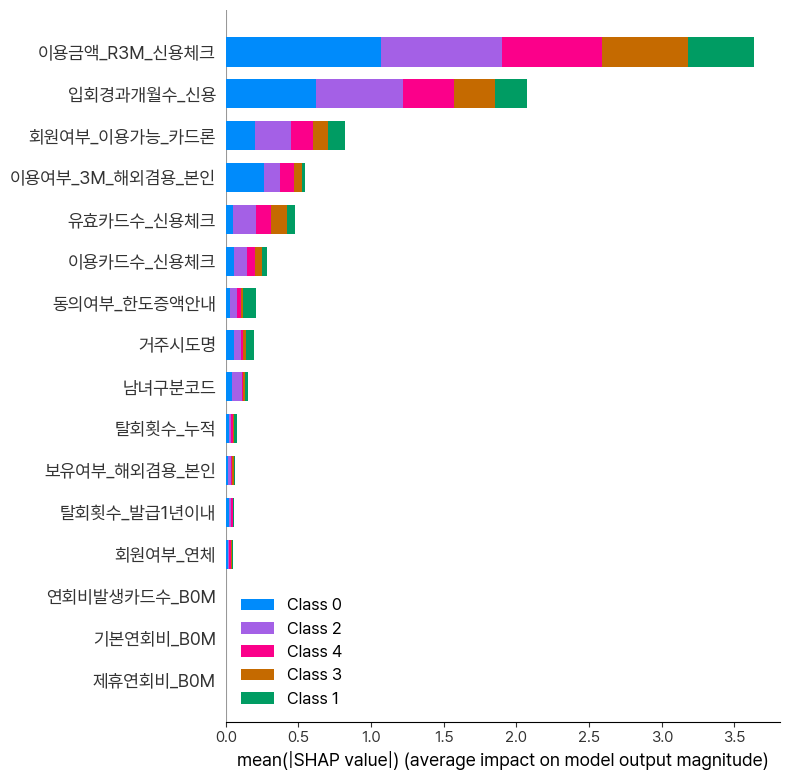

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar")

In [12]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

display(importance_df.head(30))

Feature  Importance
10    Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨    0.522822
9        Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨    0.114475
2        ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©    0.089579
12  Ïù¥Ïö©Ïó¨Î∂Ä_3M_Ìï¥Ïô∏Í≤∏Ïö©_Î≥∏Ïù∏    0.075812
1     ÌöåÏõêÏó¨Î∂Ä_Ïù¥Ïö©Í∞ÄÎä•_Ïπ¥ÎìúÎ°†    0.052720
8        Ïú†Ìö®Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨    0.029971
4       ÎèôÏùòÏó¨Î∂Ä_ÌïúÎèÑÏ¶ùÏï°ÏïàÎÇ¥    0.029424
11     Î≥¥Ïú†Ïó¨Î∂Ä_Ìï¥Ïô∏Í≤∏Ïö©_Î≥∏Ïù∏    0.021502
3           ÌöåÏõêÏó¨Î∂Ä_Ïó∞Ï≤¥    0.015426
13     Ïó∞ÌöåÎπÑÎ∞úÏÉùÏπ¥ÎìúÏàò_B0M    0.009616
6       ÌÉàÌöåÌöüÏàò_Î∞úÍ∏â1ÎÖÑÏù¥ÎÇ¥    0.009099
5           ÌÉàÌöåÌöüÏàò_ÎàÑÏ†Å    0.007400
0            ÎÇ®ÎÖÄÍµ¨Î∂ÑÏΩîÎìú    0.007164
7             Í±∞Ï£ºÏãúÎèÑÎ™Ö    0.006756
14        Í∏∞Î≥∏Ïó∞ÌöåÎπÑ_B0M    0.004793
15        Ï†úÌú¥Ïó∞ÌöåÎπÑ_B0M    0.003440

 99%|===================| 962/970 [00:45<00:00]        

üîç SHAP beeswarm plot for Segment 0


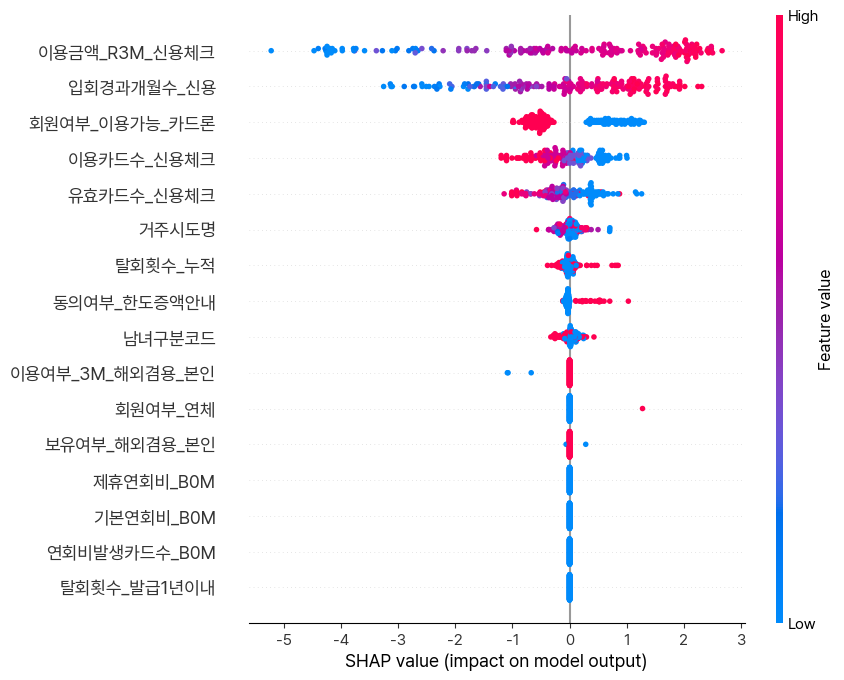

üîç SHAP beeswarm plot for Segment 1


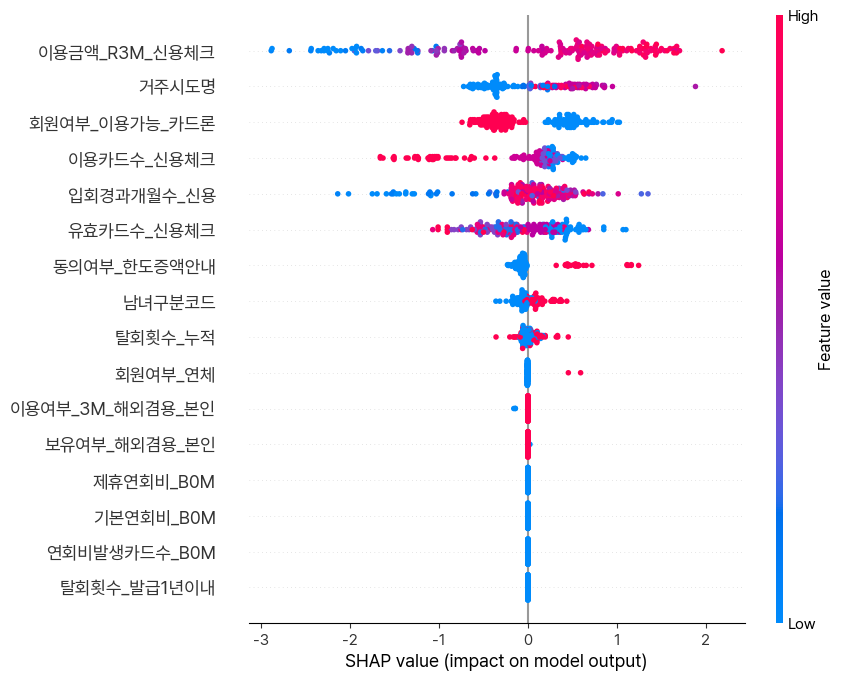

üîç SHAP beeswarm plot for Segment 2


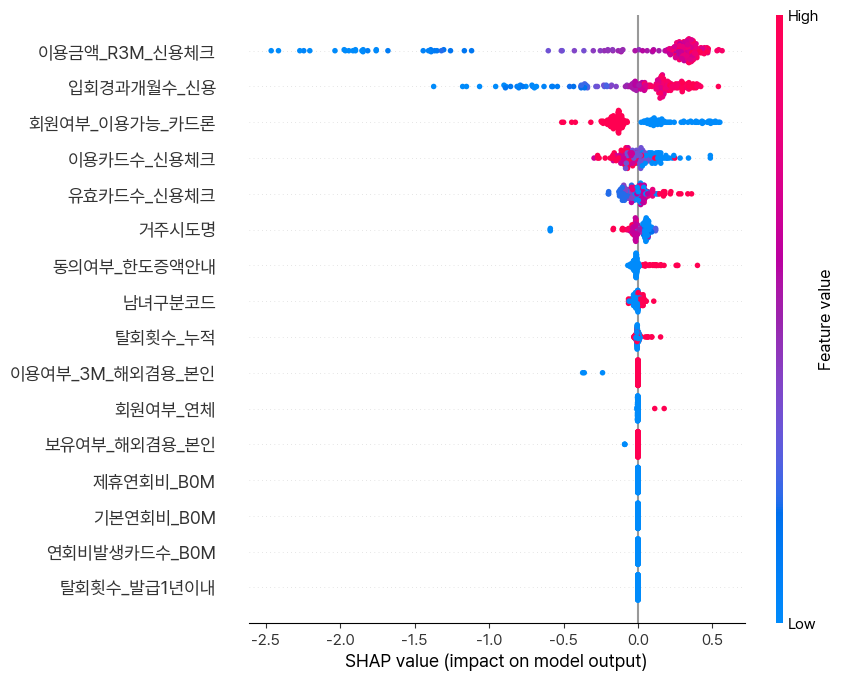

üîç SHAP beeswarm plot for Segment 3


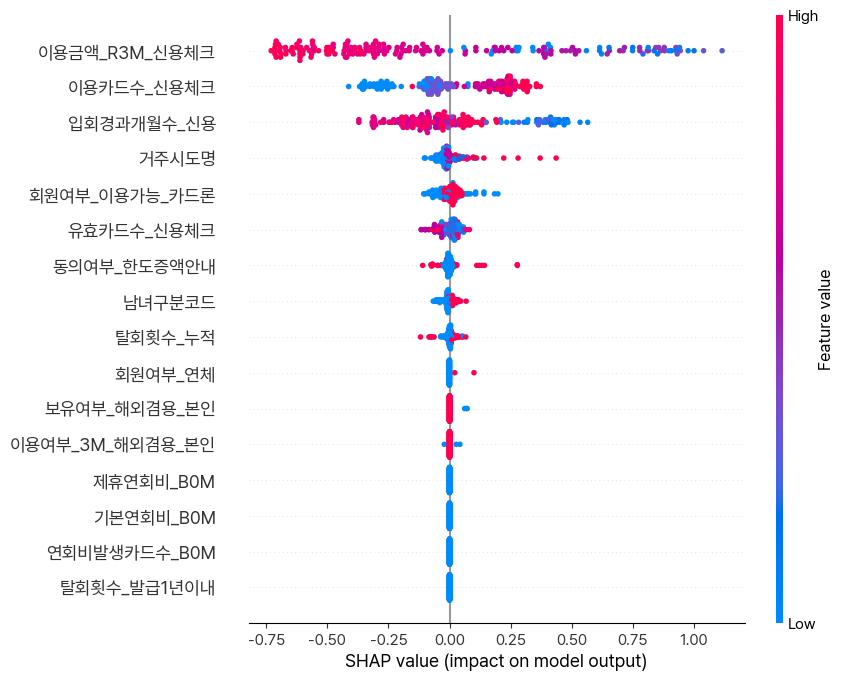

üîç SHAP beeswarm plot for Segment 4


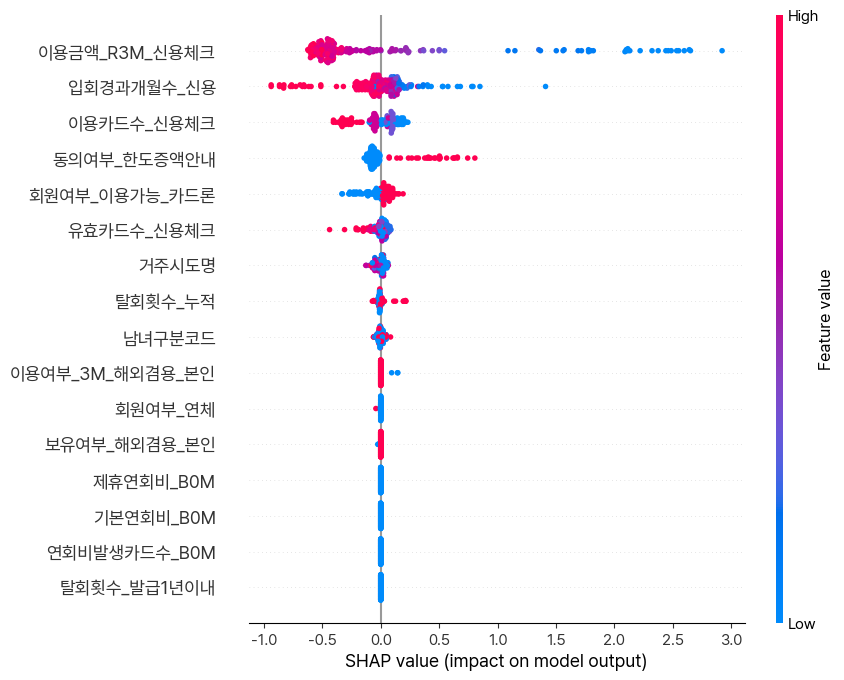

In [14]:
import shap  
import pandas as pd

# Segment 0 ÎßàÏä§ÌÇπ + Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ
mask_0 = y_val == 0
X_val_df = pd.DataFrame(X_val, columns=selected_feature)
X_val_0_all = X_val_df[mask_0]

# ÏÉòÌîå Ïàò Ï°∞Ï†ï
n_samples = min(len(X_val_0_all), 300)
X_val_0 = X_val_0_all.sample(n=n_samples, random_state=42)

# SHAP Ìï¥ÏÑù
explainer = shap.Explainer(xgb_model, X_val_0)
shap_values_0 = explainer(X_val_0)

for i in range(5):  # Segment 0 ~ 4
    print(f"üîç SHAP beeswarm plot for Segment {i}")
    shap.plots.beeswarm(shap_values_0[:, :, i], max_display=20)

1. ÌöåÏõêÏ†ïÎ≥¥ : Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨, Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨, ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©
- A
Ïã†Ïö©Ï≤¥ÌÅ¨ Ïù¥Ïö©Í∏àÏï° ÎÜíÏùå / ÎÇÆÏùÄÏÇ¨ÎûåÏù¥ Ï†àÎåÄ ÏïÑÎãò
ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàòÎèÑ ÎÜíÏùå / ÎÇÆÏùÄÏÇ¨Îûå Ï†àÎåÄ ÏïÑÎãò

- B
Ïù¥Ïö©Í∏àÏï°Ïã†Ïö©Ï≤¥ÌÅ¨ ÎÇÆÏùÄÏÇ¨Îûå Ï†àÎåÄ ÏïÑÎãò
Ïù¥Ïö©Ïπ¥ÎìúÏàò Ïã†Ïö©Ï≤¥ÌÅ¨ ÎÜíÏùÄÏÇ¨Îûå ÏïÑÎãò << ÌôïÏù∏Ìï¥Î¥êÏïºÌï†ÎìØ? Ïπ¥ÎìúÏàò Ï†ÅÎã§
ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò ÎÇÆÏùÄÏÇ¨Îûå ÏïÑÎãò (Ïû•Í∏∞Ïù¥Ïö©)

- C
Ïù¥Ïö©Í∏àÏï° Ïã†Ïö©Ï≤¥ÌÅ¨ ÎÇÆÏùÄÏÇ¨Îûå ÏïÑÎãò
ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò ÎÇÆÏùÄÏÇ¨Îûå ÏïÑÎãåÍ≤ΩÌñ• (-1.5Ïù¥Ìïò)

- D
C ÏôÄ E ÏÇ¨Ïù¥Ïùò ÏÇ¨ÎûåÎì§Ïù∏ÎìØ ÎöúÎ†∑ÌïúÍ∞í X Ïù¥Ïö©Í∏àÏï° ÎåÄÏ≤¥Î°ú ÌèâÍ∑† -1~1ÏÇ¨Ïù¥

- E
Ïù¥Ïö©Í∏àÏï° Ïã†Ïö©Ï≤¥ÌÅ¨ ÎÇÆÏùÄÏÇ¨Îûå

In [23]:
import pandas as pd

# 1. Parquet ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
file_path = "../../data/merged/ÌöåÏõêÏ†ïÎ≥¥_train.parquet"
df = pd.read_parquet(file_path)

# 2. ÌÇ§ÏõåÎìúÍ∞Ä Ìè¨Ìï®Îêú Ïª¨ÎüºÎßå ÌïÑÌÑ∞ÎßÅ
keywords = ["Ïù¥Ïö©Í∏àÏï°_", "Ïù¥Ïö©Ïπ¥ÎìúÏàò_", "ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_"]
selected_cols = [col for col in df.columns if any(k in col for k in keywords)]

# 3. ÏÑ†ÌÉùÎêú Ïª¨ÎüºÎßå Ï∂îÏ∂úÌïú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df_selected = df[selected_cols].copy()

# 4. Í≤∞Í≥º Ï∂úÎ†•
print(f"ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: {len(selected_cols)}")
print("Ïª¨Îüº Î™©Î°ù:", selected_cols)
print(df_selected.head())


ÏÑ†ÌÉùÎêú Ïª¨Îüº Ïàò: 11
Ïª¨Îüº Î™©Î°ù: ['ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©_Í∞ÄÏ°±', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨_Í∞ÄÏ°±', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©_Í∞ÄÏ°±', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ï≤¥ÌÅ¨_Í∞ÄÏ°±']
   ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©  Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨  Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©  Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©_Í∞ÄÏ°±  Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨  Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨_Í∞ÄÏ°±  \
0          67           1         1            0         0            0   
1          12           1         1            0         0            0   
2         124           1         1            0         0            0   
3          27           1         1            0         0            0   
4           2           1         0            0         1            0   

   Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨  Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©  Ïù¥Ïö©Í∏àÏï°

In [6]:
df_selected = df[selected_cols].copy()

# Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨ (ÌèâÍ∑† ÎåÄÏ≤¥)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_selected_imputed = pd.DataFrame(imputer.fit_transform(df_selected), columns=selected_cols)

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# VIF Í≥ÑÏÇ∞ Ìï®Ïàò
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

vif_result = calculate_vif(df_selected_imputed)
print(vif_result)

c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\somee\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


           Feature           VIF
1       Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨           inf
2         Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©           inf
4         Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨           inf
6    Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨  1.791020e+10
7      Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©  1.544010e+10
9      Ïù¥Ïö©Í∏àÏï°_R3M_Ï≤¥ÌÅ¨  1.285868e+09
8   Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©_Í∞ÄÏ°±  1.444262e+01
3      Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©_Í∞ÄÏ°±  1.418773e+01
0       ÏûÖÌöåÍ≤ΩÍ≥ºÍ∞úÏõîÏàò_Ïã†Ïö©  1.680552e+00
5      Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨_Í∞ÄÏ°±           NaN
10  Ïù¥Ïö©Í∏àÏï°_R3M_Ï≤¥ÌÅ¨_Í∞ÄÏ°±           NaN


In [25]:
drop_cols = [
    'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨',
    'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©Ï≤¥ÌÅ¨', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ï≤¥ÌÅ¨',
    'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ïã†Ïö©_Í∞ÄÏ°±', 'Ïù¥Ïö©Í∏àÏï°_R3M_Ïã†Ïö©_Í∞ÄÏ°±', 'Ïù¥Ïö©Ïπ¥ÎìúÏàò_Ï≤¥ÌÅ¨_Í∞ÄÏ°±'
]

In [28]:
# Í≥†Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Ï†úÍ±∞
df_reduced = df_selected.drop(columns=drop_cols)
col_reduced = df_reduced.columns.tolist()

In [29]:
# Îëê Î¶¨Ïä§Ìä∏ Ìï©ÏπòÍ∏∞
final_features = features_member + col_reduced

In [38]:
# object ÌÉÄÏûÖ Ïª¨Îüº Î¶¨Ïä§Ìä∏ ÌôïÏù∏
invalid_cols = X_train.select_dtypes(exclude=["float", "int"]).columns.tolist()
print("‚ùå Î¨∏Ï†ú Ïª¨ÎüºÎì§:", invalid_cols)

‚ùå Î¨∏Ï†ú Ïª¨ÎüºÎì§: []


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
df = pd.read_parquet("../../data/ÌÜµÌï©_train_Îç∞Ïù¥ÌÑ∞.parquet")

# 2. ÌîºÏ≤ò Î∞è ÌÉÄÍ≤ü Î∂ÑÎ¶¨
X = df[final_features].copy()
y = df["Segment"]

# 3. Î≤îÏ£ºÌòï Ïù∏ÏΩîÎî©
cat_cols = X.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
X = pd.DataFrame(SimpleImputer(strategy='mean').fit_transform(X), columns=X.columns)

# Ïä§ÏºÄÏùºÎßÅ (DataFrame ÌòïÌÉú Ïú†ÏßÄ)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ÎùºÎ≤®Ïù∏ÏΩîÎî©
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 6. train-validation Î∂ÑÌï†
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 7. XGBoost Î™®Îç∏ ÏÑ†Ïñ∏ (GPU Í∞ÄÏÜç)
xgb_model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Í∞ïÏ†ú float Î≥ÄÌôò
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

xgb_model.fit(X_train.values, y_train)
y_pred = xgb_model.predict(X_val.values)
print(classification_report(y_val, y_pred))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [16:05:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s

              precision    recall  f1-score   support

           0       0.86      0.06      0.12       194
           1       1.00      0.14      0.24        29
           2       0.64      0.36      0.46     25518
           3       0.57      0.42      0.48     69848
           4       0.90      0.96      0.93    384411

    accuracy                           0.85    480000
   macro avg       0.79      0.39      0.45    480000
weighted avg       0.83      0.85      0.84    480000

